In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.models as models

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


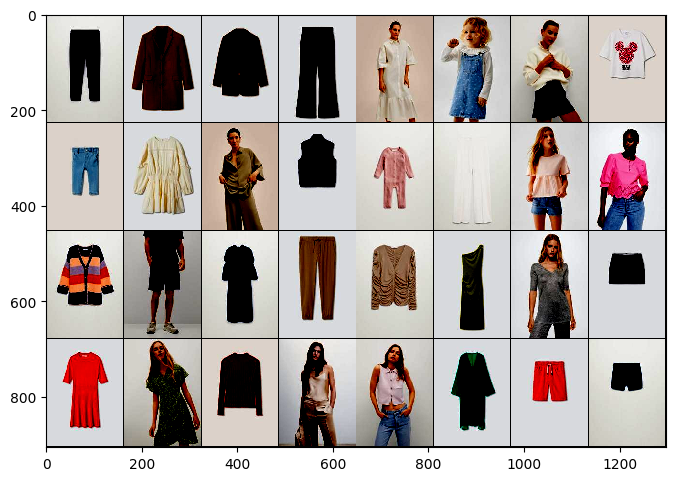

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Assuming train_data is a pandas DataFrame with columns 'des_filename' and 'label'
img_dir = './images/images/'
batch_size = 32
train_data = pd.read_csv('./data/train_data.csv')
ground_truth_dict = {
    'Top': 0,
    'Bottom': 1,
    'Shoes': 2,
    'Hats': 3
}

ground_truth=[]
cloth_id=[]

train_data = train_data[['des_filename', 'type']]

directory = os.fsencode(img_dir)
imatges = set()
i=0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    imatges.add(filename)
    
errorim = {'86_1208032_47001267-15_.jpg'}
for index, row in train_data.iterrows():
    if row['des_filename'] not in imatges:
        #delete row
        train_data.drop(index, inplace=True)
        i+=1
    if row['des_filename'] in errorim:
        train_data.drop(index, inplace=True)
        i+=1
print(i)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

traindf, valdf = train_test_split(train_data, test_size=0.2, random_state=42)

train_dataset = CustomDataset(traindf, img_dir, transform=transform)
val_dataset = CustomDataset(valdf, img_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

img, _ = next(iter(train_loader))
img_grid = make_grid(img)
plt.figure(figsize = (8, 8))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [5]:
print(torch.cuda.is_available())  # Should return True if CUDA is detected
print(torch.version.cuda) 

True
11.8


In [6]:
import torchvision.models as models

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Modify the final fully connected layer to output num_classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = ResNetClassifier(num_classes=4).to(device)

c:\Users\Arnau\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Arnau\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for inputs, labels in tqdm(train_loader, desc="Training"):
            labels = torch.tensor([ground_truth_dict[i] for i in labels])
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                labels = torch.tensor([ground_truth_dict[i] for i in labels])
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    return model

# Hyperparameters
learning_rate = 0.001
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
torch.save(trained_model.state_dict(), 'models/resnet.pth')

In [ ]:
# Load the pre-trained VGG model
vgg_model = models.vgg16(pretrained=True)

# Freeze the feature extraction layers
for param in vgg_model.features.parameters():
    param.requires_grad = False

# Modify the classifier to match the number of classes in your dataset
num_classes = len(ground_truth_dict)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

# Move the model to the appropriate device
vgg_model = vgg_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.classifier.parameters(), lr=learning_rate)

# Train the model
trained_vgg_model = train_model(
    model=vgg_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

In [ ]:
torch.save(trained_vgg_model.state_dict(), 'models/vggmodel.pth')

### Accuracy of the models

In [11]:
#load the models

vgg = models.vgg16(pretrained=True).to(device)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 4)
vgg.load_state_dict(torch.load('models/vggmodel.pth', map_location=device))
vgg.eval()

resnet = ResNetClassifier(num_classes=4).to(device)
resnet.load_state_dict(torch.load('models/resnet.pth', map_location=device))
resnet.eval()

c:\Users\Arnau\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Arnau\AppData\Local\Temp\ipykernel_19384\1612109140.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbi

ResNetClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [12]:
#accuracy: 0.9013480392156863 for VGG
# accuracy: 0.9043375563667597 for RESNET

In [ ]:
# def load_images_and_labels(images_path, train_data):
#     images = []
#     labels = []

#     image_paths = train_data['des_filename'].map(lambda x: os.path.join(images_path, x)) 
    
#     for image_path, label in tqdm(zip(image_paths, train_data['silhouette_type']), total=len(train_data), desc="Loading Images"):
#         if os.path.exists(image_path):
#             img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(img, (64, 64))
#             img_flat = img.flatten()
#             images.append(img_flat)
#             labels.append(label)

#     return np.array(images), np.array(labels)